In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle


In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
def my_snn_system(devices = "0,1,2,3",
                    my_seed = 42,
                    TIME = 8,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on
                  ):
    # 함수 내 모든 로컬 변수 저장
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0

    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices

    
    torch.manual_seed(my_seed)


    
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on)
    synapse_fc_out_features = CLASS_NUM


    ## parameter number calculator ##########################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            # elif (in_channel == 'M'): #it's a holy FC layer!
            #     img_size = img_size // 2
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ## parameter number calculator ##########################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if pre_trained == False:
        if (convTrue_fcFalse == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                     synapse_fc_trace_const1, synapse_fc_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on).to(device)
        else:
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                     synapse_conv_kernel_size, synapse_conv_stride, 
                     synapse_conv_padding, synapse_conv_trace_const1, 
                     synapse_conv_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on).to(device)
        
        if (nda_net == True):
            net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                      lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
            net.T = TIME
        net = torch.nn.DataParallel(net)
    else:
        net = torch.load(pre_trained_path)


    net = net.to(device)
    if (net_print == True):
        print(net)
    
    ## param num and memory estimation except BN at MY calculation ##########################################
    real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    if (weight_count_print == True):
        for name, param in net.named_parameters():
            if param.requires_grad:
                print(f'Layer: {name} | Number of parameters: {param.numel()}')
    # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
    # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
    print('='*50)
    print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
    memory = params_num / 8 / 1024 / 1024 # MB
    precision = 32
    memory = memory * precision 
    print(f"Memory: {memory:.2f}MiB at {precision}-bit")
    print('='*50)
    ##########################################################################

    criterion = nn.CrossEntropyLoss().to(device)
    
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler

    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    for epoch in range(epoch_num):
        print('EPOCH', epoch)
        epoch_start_time = time.time()
        running_loss = 0.0

        if (domain_il_epoch>0 and which_data == 'PMNIST'):
            k = epoch // domain_il_epoch
            xtrain=data[k]['train']['x']
            ytrain=data[k]['train']['y']
            xtest =data[k]['test']['x']
            ytest =data[k]['test']['y']

        
        iterator = enumerate(train_loader, 0)
        if (ddp_on == True):
            if torch.distributed.get_rank() == 0:   
                iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        else:
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        
        validation_interval2 = validation_interval
        if (validation_interval > len(iterator)):
            validation_interval2 = len(iterator)
            
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train()

            ## data loading #################################
            inputs, labels = data

            
            if (which_data == 'DVS_CIFAR10'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ################################################# 

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # inputs: [Time, Batch, Channel, Height, Width]   
            inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
            # inputs: [Batch, Time, Channel, Height, Width]   
            # print(inputs.size())
            outputs = net(inputs)

            batch = BATCH 
            if labels.size(0) != BATCH: 
                batch = labels.size(0)
            


            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = labels.size(0)
            correct = (predicted[0:batch] == labels).sum().item()
            tr_total += total
            tr_correct += correct
            iter_acc = correct / total
            if i % verbose_interval == verbose_interval-1:
                print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'{epoch}-{i}/{len(train_loader)} iter_acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            

            loss = criterion(outputs[0:batch,:], labels)
            loss.backward()


            ### gradinet verbose ##########################################
            if (gradient_verbose == True):
                if (i % verbose_interval == verbose_interval-1):
                    print('\n\nepoch', epoch, 'iter', i)
                    for name, param in net.named_parameters():
                        if param.requires_grad:
                            print('\n\n\n\n' , name, param.grad)
            ################################################################
            
            optimizer.step()

            running_loss += loss.item()
            # print("Epoch: {}, Iter: {}, Loss: {}".format(epoch + 1, i + 1, running_loss / 100))

            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##############################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval()
                    for data in test_loader:
                        ## data loading #################################
                        inputs, labels = data

                        
                        if (which_data == 'DVS_CIFAR10'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ################################################# 

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = net(inputs.permute(1, 0, 2, 3, 4))
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        batch = BATCH 
                        if labels.size(0) != BATCH: 
                            batch = labels.size(0)
                        correct += (predicted[0:batch] == labels).sum().item()
                        val_loss = criterion(outputs[0:batch,:], labels)

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    torch.save(net.state_dict(), "net_save/save_now_net_weights.pth")
                    torch.save(net, "net_save/save_now_net.pth")
                    torch.save(net.module.state_dict(), "net_save/save_now_net_weights2.pth")
                    torch.save(net.module, "net_save/save_now_net2.pth")
            ################################################################
            iterator.set_description(f"iter_acc: {iter_acc_string}, iter_loss: {loss}, val_acc: {100 * val_acc_now:.2f}%")  

            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            iter_acc_file_name = f'result_save/{base_name}_iter_acc_array.npy'
            tr_acc_file_name = f'result_save/{base_name}_tr_acc_array.npy'
            val_acc_file_name = f'result_save/{base_name}_val_acc_now_array.npy'
            hyperparameters_file_name = f'result_save/{base_name}_hyperparameters.json'

            hyperparameters['current epoch'] = epoch

            # 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기)
            # np.save(iter_acc_file_name, iter_acc_array)
            # np.save(val_acc_file_name, val_acc_now_array)
            # with open(hyperparameters_file_name, 'w') as f:
            #     json.dump(hyperparameters, f, indent=4)

            np.save('result_save/iter_acc_array.npy', iter_acc_array)
            np.save('result_save/tr_acc_array.npy', tr_acc_array)
            np.save('result_save/val_acc_now_array.npy', val_acc_now_array)
            with open('result_save/hyperparameters.json', 'w') as f:
                json.dump(hyperparameters, f, indent=4)
            
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        
        epoch_time_end = time.time()
        epoch_time = epoch_time_end - epoch_start_time  # 실행 시간 계산
        
        print(f"epoch_time: {epoch_time} seconds")
        print('\n')


In [5]:
### my_snn control board ########################
decay = 0.25 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5

my_snn_system(  devices = "0,1,2,3,4,5",
                my_seed = 42,
                TIME = 10, # dvscifar 10 # ottt 6 or 10 # nda 10
                BATCH = 256, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 48, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = 'DVS_CIFAR10',# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = True, # True # False

                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 0.5,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 10000, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1,
                synapse_conv_trace_const2 = decay, # lif_layer_v_decay

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1,
                synapse_fc_trace_const2 = decay, # lif_layer_v_decay

                pre_trained = False, # True # False
                convTrue_fcFalse = True, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # 10000 이상은 separable, 20000이상은 depthwise
                # cfg = [64],
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
                cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [64], 
                
                net_print = True, # True # False
                weight_count_print = False, # True # False
                pre_trained_path = "net_save/save_now_net.pth",
                learning_rate = 0.001, # default 0.001  # ottt 0.1  # nda 0.001
                epoch_num = 200,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐
                validation_interval = 999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함
                tdBN_on = True,  # True # False
                BN_on = False,  # True # False
                
                surrogate = 'rough_rectangle', # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = True,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'Adam', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling이 낫다.

# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


DataParallel(
  (module): MY_SNN_CONV(
    (layers): Sequential(
      (0): SYNAPSE_CONV_BPTT()
      (1): tdBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LIF_layer()
      (3): DimChanger_for_pooling(
        (ann_module): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
      (4): SYNAPSE_CONV_BPTT()
      (5): tdBatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): LIF_layer()
      (7): DimChanger_for_pooling(
        (ann_module): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
      (8): SYNAPSE_CONV_BPTT()
      (9): tdBatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LIF_layer()
      (11): SYNAPSE_CONV_BPTT()
      (12): tdBatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): LIF_layer()
      (14): DimChanger_for_pooling(
        (ann_module): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
      (15): SY

train: 0-35/36 tr_acc: 40.00%, lr=['0.001'], tr_loss: 1.6863555908203125, val_acc: 21.70%: 100%|██████████| 36/36 [00:35<00:00,  1.02it/s]

epoch_time: 35.306092262268066 seconds


EPOCH 1



train: 1-35/36 tr_acc: 32.50%, lr=['0.0009999383162408303'], tr_loss: 1.9066581726074219, val_acc: 38.40%: 100%|██████████| 36/36 [00:30<00:00,  1.18it/s]

epoch_time: 30.66954731941223 seconds


EPOCH 2



train: 2-35/36 tr_acc: 42.50%, lr=['0.0009997532801828658'], tr_loss: 1.7537486553192139, val_acc: 37.70%: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]

epoch_time: 23.043044567108154 seconds


EPOCH 3



train: 3-35/36 tr_acc: 35.00%, lr=['0.0009994449374809851'], tr_loss: 1.6641838550567627, val_acc: 39.10%: 100%|██████████| 36/36 [00:18<00:00,  1.93it/s]

epoch_time: 18.95796036720276 seconds


EPOCH 4



train: 4-35/36 tr_acc: 42.50%, lr=['0.0009990133642141358'], tr_loss: 1.6208242177963257, val_acc: 34.00%: 100%|██████████| 36/36 [00:18<00:00,  1.98it/s]

epoch_time: 18.43138813972473 seconds


EPOCH 5



train: 5-35/36 tr_acc: 47.50%, lr=['0.000998458666866564'], tr_loss: 1.474717378616333, val_acc: 30.50%: 100%|██████████| 36/36 [00:21<00:00,  1.65it/s] 

epoch_time: 22.031443119049072 seconds


EPOCH 6



train: 6-35/36 tr_acc: 42.50%, lr=['0.00099778098230154'], tr_loss: 1.5349156856536865, val_acc: 42.70%: 100%|██████████| 36/36 [00:24<00:00,  1.48it/s]

epoch_time: 24.523239850997925 seconds


EPOCH 7



train: 7-35/36 tr_acc: 47.50%, lr=['0.0009969804777275899'], tr_loss: 1.5778915882110596, val_acc: 49.60%: 100%|██████████| 36/36 [00:25<00:00,  1.39it/s]

epoch_time: 26.19348669052124 seconds


EPOCH 8



train: 8-35/36 tr_acc: 47.50%, lr=['0.000996057350657239'], tr_loss: 1.4984854459762573, val_acc: 24.60%: 100%|██████████| 36/36 [00:19<00:00,  1.83it/s]

epoch_time: 19.894014596939087 seconds


EPOCH 9



train: 9-35/36 tr_acc: 65.00%, lr=['0.0009950118288582787'], tr_loss: 1.0841102600097656, val_acc: 43.60%: 100%|██████████| 36/36 [00:19<00:00,  1.86it/s]

epoch_time: 19.62127995491028 seconds


EPOCH 10



train: 10-35/36 tr_acc: 70.00%, lr=['0.0009938441702975688'], tr_loss: 1.0890659093856812, val_acc: 28.70%: 100%|██████████| 36/36 [00:20<00:00,  1.78it/s]

epoch_time: 20.48008108139038 seconds


EPOCH 11



train: 11-35/36 tr_acc: 52.50%, lr=['0.000992554663077387'], tr_loss: 1.2572438716888428, val_acc: 45.80%: 100%|██████████| 36/36 [00:18<00:00,  1.97it/s]

epoch_time: 18.512234449386597 seconds


EPOCH 12



train: 12-35/36 tr_acc: 60.00%, lr=['0.0009911436253643444'], tr_loss: 1.2051573991775513, val_acc: 52.00%: 100%|██████████| 36/36 [00:19<00:00,  1.81it/s]

epoch_time: 20.21348476409912 seconds


EPOCH 13



train: 13-35/36 tr_acc: 45.00%, lr=['0.0009896114053108828'], tr_loss: 1.4241753816604614, val_acc: 41.00%: 100%|██████████| 36/36 [00:18<00:00,  1.97it/s]

epoch_time: 18.58003306388855 seconds


EPOCH 14



train: 14-35/36 tr_acc: 57.50%, lr=['0.0009879583809693736'], tr_loss: 1.3559277057647705, val_acc: 50.00%: 100%|██████████| 36/36 [00:18<00:00,  1.99it/s]

epoch_time: 18.354480266571045 seconds


EPOCH 15



train: 15-35/36 tr_acc: 70.00%, lr=['0.0009861849601988382'], tr_loss: 0.9286689758300781, val_acc: 54.70%: 100%|██████████| 36/36 [00:20<00:00,  1.77it/s]

epoch_time: 20.627167224884033 seconds


EPOCH 16



train: 16-35/36 tr_acc: 55.00%, lr=['0.0009842915805643154'], tr_loss: 1.3828867673873901, val_acc: 52.20%: 100%|██████████| 36/36 [00:18<00:00,  1.97it/s]

epoch_time: 18.487215518951416 seconds


EPOCH 17



train: 17-35/36 tr_acc: 62.50%, lr=['0.000982278709228899'], tr_loss: 1.1845905780792236, val_acc: 56.00%: 100%|██████████| 36/36 [00:19<00:00,  1.80it/s]

epoch_time: 20.27885365486145 seconds


EPOCH 18



train: 18-35/36 tr_acc: 50.00%, lr=['0.0009801468428384714'], tr_loss: 1.4101289510726929, val_acc: 52.50%: 100%|██████████| 36/36 [00:19<00:00,  1.89it/s]

epoch_time: 19.2575364112854 seconds


EPOCH 19



train: 19-35/36 tr_acc: 52.50%, lr=['0.0009778965073991648'], tr_loss: 1.1772292852401733, val_acc: 40.40%: 100%|██████████| 36/36 [00:18<00:00,  1.99it/s]

epoch_time: 18.36177706718445 seconds


EPOCH 20



train: 20-35/36 tr_acc: 80.00%, lr=['0.0009755282581475766'], tr_loss: 0.7350703477859497, val_acc: 53.90%: 100%|██████████| 36/36 [00:20<00:00,  1.80it/s]

epoch_time: 20.29076838493347 seconds


EPOCH 21



train: 21-35/36 tr_acc: 62.50%, lr=['0.0009730426794137723'], tr_loss: 1.4045535326004028, val_acc: 47.90%: 100%|██████████| 36/36 [00:19<00:00,  1.81it/s]

epoch_time: 20.142475366592407 seconds


EPOCH 22



train: 22-35/36 tr_acc: 67.50%, lr=['0.0009704403844771124'], tr_loss: 0.8440557718276978, val_acc: 44.90%: 100%|██████████| 36/36 [00:18<00:00,  2.00it/s]

epoch_time: 18.272230625152588 seconds


EPOCH 23



train: 23-35/36 tr_acc: 75.00%, lr=['0.0009677220154149334'], tr_loss: 0.8931339979171753, val_acc: 49.10%: 100%|██████████| 36/36 [00:18<00:00,  1.92it/s]

epoch_time: 18.94670009613037 seconds


EPOCH 24



train: 24-35/36 tr_acc: 57.50%, lr=['0.0009648882429441253'], tr_loss: 1.0244872570037842, val_acc: 37.90%: 100%|██████████| 36/36 [00:19<00:00,  1.82it/s]

epoch_time: 20.07473087310791 seconds


EPOCH 25



train: 25-35/36 tr_acc: 65.00%, lr=['0.000961939766255643'], tr_loss: 0.9356997609138489, val_acc: 56.40%: 100%|██████████| 36/36 [00:18<00:00,  1.92it/s]

epoch_time: 18.97234272956848 seconds


EPOCH 26



train: 26-35/36 tr_acc: 67.50%, lr=['0.0009588773128419901'], tr_loss: 0.8811845779418945, val_acc: 35.80%: 100%|██████████| 36/36 [00:18<00:00,  1.98it/s]

epoch_time: 18.380084991455078 seconds


EPOCH 27



train: 27-35/36 tr_acc: 77.50%, lr=['0.0009557016383177221'], tr_loss: 0.6567920446395874, val_acc: 60.20%: 100%|██████████| 36/36 [00:18<00:00,  1.92it/s]

epoch_time: 18.998839616775513 seconds


EPOCH 28



train: 28-35/36 tr_acc: 70.00%, lr=['0.0009524135262330093'], tr_loss: 1.177140474319458, val_acc: 45.10%: 100%|██████████| 36/36 [00:18<00:00,  1.99it/s]  

epoch_time: 18.41406512260437 seconds


EPOCH 29



train: 29-35/36 tr_acc: 77.50%, lr=['0.0009490137878803073'], tr_loss: 0.6947282552719116, val_acc: 55.70%: 100%|██████████| 36/36 [00:18<00:00,  1.99it/s]

epoch_time: 18.31026577949524 seconds


EPOCH 30



train: 30-35/36 tr_acc: 67.50%, lr=['0.0009455032620941834'], tr_loss: 0.8779233694076538, val_acc: 58.80%: 100%|██████████| 36/36 [00:18<00:00,  1.97it/s] 

epoch_time: 18.51437258720398 seconds


EPOCH 31



train: 31-35/36 tr_acc: 77.50%, lr=['0.0009418828150443463'], tr_loss: 0.5636662840843201, val_acc: 45.80%: 100%|██████████| 36/36 [00:18<00:00,  1.99it/s]

epoch_time: 18.355321168899536 seconds


EPOCH 32



train: 32-35/36 tr_acc: 72.50%, lr=['0.0009381533400219311'], tr_loss: 0.7423993945121765, val_acc: 41.90%: 100%|██████████| 36/36 [00:18<00:00,  1.97it/s] 

epoch_time: 18.520304679870605 seconds


EPOCH 33



train: 33-35/36 tr_acc: 70.00%, lr=['0.0009343157572190951'], tr_loss: 0.8220909237861633, val_acc: 52.20%: 100%|██████████| 36/36 [00:18<00:00,  2.00it/s]

epoch_time: 18.280023097991943 seconds


EPOCH 34



train: 34-35/36 tr_acc: 82.50%, lr=['0.0009303710135019713'], tr_loss: 0.6303275227546692, val_acc: 57.40%: 100%|██████████| 36/36 [00:18<00:00,  1.97it/s] 

epoch_time: 18.519224882125854 seconds


EPOCH 35



train: 35-35/36 tr_acc: 77.50%, lr=['0.0009263200821770456'], tr_loss: 0.5933806896209717, val_acc: 61.00%: 100%|██████████| 36/36 [00:18<00:00,  1.92it/s] 

epoch_time: 18.954652309417725 seconds


EPOCH 36



train: 36-35/36 tr_acc: 87.50%, lr=['0.000922163962751007'], tr_loss: 0.6327648162841797, val_acc: 43.00%: 100%|██████████| 36/36 [00:18<00:00,  1.99it/s] 

epoch_time: 18.351886510849 seconds


EPOCH 37



train: 37-35/36 tr_acc: 65.00%, lr=['0.0009179036806841347'], tr_loss: 0.8896777033805847, val_acc: 57.40%: 100%|██████████| 36/36 [00:18<00:00,  1.97it/s] 

epoch_time: 18.464823484420776 seconds


EPOCH 38



train: 38-35/36 tr_acc: 65.00%, lr=['0.0009135402871372803'], tr_loss: 0.7896372675895691, val_acc: 62.60%: 100%|██████████| 36/36 [00:18<00:00,  1.94it/s] 

epoch_time: 18.780038356781006 seconds


EPOCH 39



train: 39-35/36 tr_acc: 72.50%, lr=['0.0009090748587125112'], tr_loss: 0.7995843291282654, val_acc: 52.80%: 100%|██████████| 36/36 [00:18<00:00,  1.99it/s] 

epoch_time: 18.38848853111267 seconds


EPOCH 40



train: 40-35/36 tr_acc: 85.00%, lr=['0.0009045084971874732'], tr_loss: 0.41955986618995667, val_acc: 50.10%: 100%|██████████| 36/36 [00:18<00:00,  1.98it/s]

epoch_time: 18.414873838424683 seconds


EPOCH 41



train: 41-35/36 tr_acc: 82.50%, lr=['0.0008998423292435448'], tr_loss: 0.5536114573478699, val_acc: 59.10%: 100%|██████████| 36/36 [00:17<00:00,  2.01it/s] 

epoch_time: 18.190501928329468 seconds


EPOCH 42



train: 42-35/36 tr_acc: 75.00%, lr=['0.0008950775061878446'], tr_loss: 0.6175128817558289, val_acc: 59.70%: 100%|██████████| 36/36 [00:18<00:00,  1.97it/s] 

epoch_time: 18.49581265449524 seconds


EPOCH 43



train: 43-35/36 tr_acc: 72.50%, lr=['0.0008902152036691643'], tr_loss: 0.8208012580871582, val_acc: 53.90%: 100%|██████████| 36/36 [00:18<00:00,  1.95it/s] 

epoch_time: 18.6930148601532 seconds


EPOCH 44



train: 44-35/36 tr_acc: 80.00%, lr=['0.000885256621387894'], tr_loss: 0.5304340720176697, val_acc: 47.80%: 100%|██████████| 36/36 [00:18<00:00,  1.99it/s] 

epoch_time: 18.367427110671997 seconds


EPOCH 45



train: 45-35/36 tr_acc: 80.00%, lr=['0.0008802029828000149'], tr_loss: 0.6691265106201172, val_acc: 62.30%: 100%|██████████| 36/36 [00:18<00:00,  1.97it/s] 

epoch_time: 18.526092529296875 seconds


EPOCH 46



train: 46-35/36 tr_acc: 87.50%, lr=['0.0008750555348152292'], tr_loss: 0.4708114564418793, val_acc: 61.40%: 100%|██████████| 36/36 [00:18<00:00,  1.92it/s] 

epoch_time: 18.956056356430054 seconds


EPOCH 47



train: 47-35/36 tr_acc: 75.00%, lr=['0.0008698155474893041'], tr_loss: 0.7751772999763489, val_acc: 63.30%: 100%|██████████| 36/36 [00:18<00:00,  1.90it/s] 

epoch_time: 19.153443813323975 seconds


EPOCH 48



train: 48-35/36 tr_acc: 87.50%, lr=['0.0008644843137107051'], tr_loss: 0.32517048716545105, val_acc: 59.90%: 100%|██████████| 36/36 [00:18<00:00,  1.99it/s]

epoch_time: 18.408161401748657 seconds


EPOCH 49



train: 49-35/36 tr_acc: 85.00%, lr=['0.0008590631488815938'], tr_loss: 0.574918806552887, val_acc: 59.70%: 100%|██████████| 36/36 [00:18<00:00,  1.98it/s]  

epoch_time: 18.407063961029053 seconds


EPOCH 50



train: 50-35/36 tr_acc: 72.50%, lr=['0.0008535533905932731'], tr_loss: 0.8607900738716125, val_acc: 51.30%: 100%|██████████| 36/36 [00:18<00:00,  2.00it/s] 

epoch_time: 18.266592025756836 seconds


EPOCH 51



train: 51-35/36 tr_acc: 85.00%, lr=['0.0008479563982961564'], tr_loss: 0.3956076502799988, val_acc: 65.90%: 100%|██████████| 36/36 [00:18<00:00,  1.91it/s] 

epoch_time: 19.077476501464844 seconds


EPOCH 52



train: 52-35/36 tr_acc: 87.50%, lr=['0.0008422735529643437'], tr_loss: 0.37356558442115784, val_acc: 58.60%: 100%|██████████| 36/36 [00:18<00:00,  1.98it/s]

epoch_time: 18.426120281219482 seconds


EPOCH 53



train: 53-35/36 tr_acc: 85.00%, lr=['0.000836506256754886'], tr_loss: 0.6603372097015381, val_acc: 60.00%: 100%|██████████| 36/36 [00:18<00:00,  1.94it/s] 

epoch_time: 18.814475297927856 seconds


EPOCH 54



train: 54-35/36 tr_acc: 75.00%, lr=['0.0008306559326618253'], tr_loss: 0.7047519683837891, val_acc: 54.80%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s] 

epoch_time: 24.003236770629883 seconds


EPOCH 55



train: 55-35/36 tr_acc: 80.00%, lr=['0.0008247240241650912'], tr_loss: 0.5947173237800598, val_acc: 60.10%: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s] 

epoch_time: 23.375664710998535 seconds


EPOCH 56



train: 56-35/36 tr_acc: 80.00%, lr=['0.0008187119948743442'], tr_loss: 0.4774750769138336, val_acc: 59.70%: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s] 

epoch_time: 23.123506784439087 seconds


EPOCH 57



train: 57-35/36 tr_acc: 77.50%, lr=['0.000812621328167852'], tr_loss: 0.5784624814987183, val_acc: 57.50%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s] 

epoch_time: 23.559754371643066 seconds


EPOCH 58



train: 58-35/36 tr_acc: 80.00%, lr=['0.0008064535268264877'], tr_loss: 0.6346770524978638, val_acc: 61.10%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s] 

epoch_time: 23.558201551437378 seconds


EPOCH 59



train: 59-35/36 tr_acc: 77.50%, lr=['0.0008002101126629415'], tr_loss: 0.7368165254592896, val_acc: 63.70%: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s] 

epoch_time: 23.335017919540405 seconds


EPOCH 60



train: 60-35/36 tr_acc: 82.50%, lr=['0.000793892626146236'], tr_loss: 0.4838203489780426, val_acc: 58.10%: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s] 

epoch_time: 23.28839087486267 seconds


EPOCH 61



train: 61-35/36 tr_acc: 82.50%, lr=['0.0007875026260216388'], tr_loss: 0.508841872215271, val_acc: 60.90%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]  

epoch_time: 23.98103165626526 seconds


EPOCH 62



train: 62-35/36 tr_acc: 85.00%, lr=['0.0007810416889260649'], tr_loss: 0.47300171852111816, val_acc: 63.70%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]

epoch_time: 23.61565923690796 seconds


EPOCH 63



train: 63-35/36 tr_acc: 82.50%, lr=['0.0007745114089990654'], tr_loss: 0.5546097755432129, val_acc: 61.20%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s] 

epoch_time: 23.677772521972656 seconds


EPOCH 64



train: 64-35/36 tr_acc: 95.00%, lr=['0.0007679133974894978'], tr_loss: 0.2626105844974518, val_acc: 66.20%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s] 

epoch_time: 23.85303544998169 seconds


EPOCH 65



train: 65-35/36 tr_acc: 90.00%, lr=['0.0007612492823579739'], tr_loss: 0.298006534576416, val_acc: 62.00%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]  

epoch_time: 23.742087841033936 seconds


EPOCH 66



train: 66-35/36 tr_acc: 77.50%, lr=['0.0007545207078751852'], tr_loss: 0.5511106252670288, val_acc: 58.30%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s] 

epoch_time: 23.490408420562744 seconds


EPOCH 67



train: 67-35/36 tr_acc: 90.00%, lr=['0.0007477293342162034'], tr_loss: 0.35724586248397827, val_acc: 58.80%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]

epoch_time: 23.465405225753784 seconds


EPOCH 68



train: 68-35/36 tr_acc: 87.50%, lr=['0.0007408768370508571'], tr_loss: 0.3500226140022278, val_acc: 60.10%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s] 

epoch_time: 23.678836584091187 seconds


EPOCH 69



train: 69-35/36 tr_acc: 77.50%, lr=['0.0007339649071302863'], tr_loss: 0.6723572015762329, val_acc: 62.90%: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s] 

epoch_time: 23.14401078224182 seconds


EPOCH 70



train: 70-35/36 tr_acc: 87.50%, lr=['0.0007269952498697729'], tr_loss: 0.3064388930797577, val_acc: 58.80%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s] 


epoch_time: 23.670541048049927 seconds


EPOCH 71


train: 71-35/36 tr_acc: 95.00%, lr=['0.000719969584927957'], tr_loss: 0.1850922554731369, val_acc: 63.10%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s] 

epoch_time: 23.50412678718567 seconds


EPOCH 72



train: 72-35/36 tr_acc: 85.00%, lr=['0.0007128896457825358'], tr_loss: 0.5388271808624268, val_acc: 60.80%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s] 

epoch_time: 23.631659030914307 seconds


EPOCH 73



train: 73-35/36 tr_acc: 87.50%, lr=['0.0007057571793025539'], tr_loss: 0.2703160345554352, val_acc: 65.10%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s] 

epoch_time: 23.709185123443604 seconds


EPOCH 74



train: 74-35/36 tr_acc: 80.00%, lr=['0.0006985739453173898'], tr_loss: 0.6090951561927795, val_acc: 60.30%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s] 

epoch_time: 23.41117215156555 seconds


EPOCH 75



train: 75-35/36 tr_acc: 90.00%, lr=['0.0006913417161825444'], tr_loss: 0.30965936183929443, val_acc: 61.10%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]

epoch_time: 23.700358152389526 seconds


EPOCH 76



train: 76-35/36 tr_acc: 92.50%, lr=['0.0006840622763423385'], tr_loss: 0.3352929949760437, val_acc: 63.40%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s] 

epoch_time: 23.394649982452393 seconds


EPOCH 77



train: 77-35/36 tr_acc: 82.50%, lr=['0.000676737421889628'], tr_loss: 0.6480538845062256, val_acc: 60.90%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s] 

epoch_time: 23.515900135040283 seconds


EPOCH 78



train: 78-35/36 tr_acc: 72.50%, lr=['0.0006693689601226452'], tr_loss: 0.7407980561256409, val_acc: 59.80%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s] 

epoch_time: 23.82081174850464 seconds


EPOCH 79



train: 79-35/36 tr_acc: 90.00%, lr=['0.0006619587090990741'], tr_loss: 0.39040201902389526, val_acc: 57.90%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]

epoch_time: 23.61038565635681 seconds


EPOCH 80



train: 80-35/36 tr_acc: 92.50%, lr=['0.0006545084971874731'], tr_loss: 0.2668406069278717, val_acc: 61.20%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s] 

epoch_time: 23.65033531188965 seconds


EPOCH 81



train: 81-35/36 tr_acc: 92.50%, lr=['0.0006470201626161514'], tr_loss: 0.23760762810707092, val_acc: 59.50%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]

epoch_time: 23.622132301330566 seconds


EPOCH 82



train: 82-35/36 tr_acc: 77.50%, lr=['0.0006394955530196142'], tr_loss: 0.5086349248886108, val_acc: 64.00%: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s] 

epoch_time: 23.383107900619507 seconds


EPOCH 83



train: 83-35/36 tr_acc: 87.50%, lr=['0.0006319365249826858'], tr_loss: 0.4499719738960266, val_acc: 61.40%: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s] 

epoch_time: 23.40257215499878 seconds


EPOCH 84



train: 84-35/36 tr_acc: 90.00%, lr=['0.0006243449435824268'], tr_loss: 0.28420528769493103, val_acc: 63.80%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]

epoch_time: 23.72216272354126 seconds


EPOCH 85



train: 85-35/36 tr_acc: 87.50%, lr=['0.0006167226819279523'], tr_loss: 0.31075114011764526, val_acc: 48.50%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]

epoch_time: 23.649622917175293 seconds


EPOCH 86



train: 86-35/36 tr_acc: 90.00%, lr=['0.0006090716206982709'], tr_loss: 0.2521587610244751, val_acc: 63.50%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s] 

epoch_time: 23.50552988052368 seconds


EPOCH 87



train: 87-35/36 tr_acc: 92.50%, lr=['0.0006013936476782558'], tr_loss: 0.2267206460237503, val_acc: 62.10%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s] 


epoch_time: 23.819912672042847 seconds


EPOCH 88


train: 88-35/36 tr_acc: 82.50%, lr=['0.000593690657292862'], tr_loss: 0.4507118761539459, val_acc: 65.20%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s] 

epoch_time: 23.49972105026245 seconds


EPOCH 89



train: 89-35/36 tr_acc: 90.00%, lr=['0.0005859645501397043'], tr_loss: 0.26484766602516174, val_acc: 61.80%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]

epoch_time: 23.791444063186646 seconds


EPOCH 90



train: 90-35/36 tr_acc: 85.00%, lr=['0.000578217232520115'], tr_loss: 0.47767549753189087, val_acc: 64.80%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]

epoch_time: 23.703660011291504 seconds


EPOCH 91



train: 91-35/36 tr_acc: 87.50%, lr=['0.000570450615968791'], tr_loss: 0.4976731240749359, val_acc: 61.30%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s] 

epoch_time: 23.85104274749756 seconds


EPOCH 92



train: 92-35/36 tr_acc: 97.50%, lr=['0.0005626666167821518'], tr_loss: 0.15818843245506287, val_acc: 63.60%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]

epoch_time: 23.757746696472168 seconds


EPOCH 93



train: 93-35/36 tr_acc: 95.00%, lr=['0.0005548671555455222'], tr_loss: 0.1500225067138672, val_acc: 62.90%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s] 

epoch_time: 23.519272089004517 seconds


EPOCH 94



train: 94-35/36 tr_acc: 90.00%, lr=['0.0005470541566592567'], tr_loss: 0.41643157601356506, val_acc: 66.20%: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s]

epoch_time: 23.382997751235962 seconds


EPOCH 95



train: 95-35/36 tr_acc: 75.00%, lr=['0.000539229547863922'], tr_loss: 0.6178575754165649, val_acc: 65.20%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s] 

epoch_time: 23.729727268218994 seconds


EPOCH 96



train: 96-35/36 tr_acc: 90.00%, lr=['0.0005313952597646562'], tr_loss: 0.5151091814041138, val_acc: 61.10%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s] 

epoch_time: 23.659889698028564 seconds


EPOCH 97



train: 97-35/36 tr_acc: 85.00%, lr=['0.0005235532253548208'], tr_loss: 0.5238288640975952, val_acc: 63.80%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s] 

epoch_time: 23.881572008132935 seconds


EPOCH 98



train: 98-35/36 tr_acc: 90.00%, lr=['0.0005157053795390637'], tr_loss: 0.31497055292129517, val_acc: 63.20%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]

epoch_time: 23.70105481147766 seconds


EPOCH 99



train: 99-35/36 tr_acc: 95.00%, lr=['0.0005078536586559099'], tr_loss: 0.27268314361572266, val_acc: 67.40%: 100%|██████████| 36/36 [00:24<00:00,  1.49it/s]

epoch_time: 24.478957414627075 seconds


EPOCH 100



train: 100-35/36 tr_acc: 92.50%, lr=['0.0004999999999999996'], tr_loss: 0.2496016025543213, val_acc: 64.70%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s] 

epoch_time: 23.47054958343506 seconds


EPOCH 101



train: 101-35/36 tr_acc: 90.00%, lr=['0.0004921463413440893'], tr_loss: 0.365186870098114, val_acc: 64.70%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]  

epoch_time: 23.642252683639526 seconds


EPOCH 102



train: 102-35/36 tr_acc: 92.50%, lr=['0.0004842946204609354'], tr_loss: 0.2456263303756714, val_acc: 67.90%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s] 

epoch_time: 23.985454559326172 seconds


EPOCH 103



train: 103-35/36 tr_acc: 90.00%, lr=['0.00047644677464517824'], tr_loss: 0.18622121214866638, val_acc: 67.40%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]

epoch_time: 23.52513551712036 seconds


EPOCH 104



train: 104-35/36 tr_acc: 95.00%, lr=['0.00046860474023534287'], tr_loss: 0.21560640633106232, val_acc: 62.40%: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s] 

epoch_time: 23.150856733322144 seconds


EPOCH 105



train: 105-35/36 tr_acc: 90.00%, lr=['0.00046077045213607716'], tr_loss: 0.48011165857315063, val_acc: 63.80%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]

epoch_time: 23.519317865371704 seconds


EPOCH 106



train: 106-35/36 tr_acc: 87.50%, lr=['0.0004529458433407424'], tr_loss: 0.4997238218784332, val_acc: 66.90%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s] 

epoch_time: 23.775684595108032 seconds


EPOCH 107



train: 107-35/36 tr_acc: 95.00%, lr=['0.000445132844454477'], tr_loss: 0.174770325422287, val_acc: 63.40%: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]  

epoch_time: 24.275949239730835 seconds


EPOCH 108



train: 108-35/36 tr_acc: 90.00%, lr=['0.0004373333832178475'], tr_loss: 0.37723177671432495, val_acc: 67.30%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]

epoch_time: 23.517626762390137 seconds


EPOCH 109



train: 109-35/36 tr_acc: 82.50%, lr=['0.0004295493840312084'], tr_loss: 0.39733177423477173, val_acc: 62.80%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]

epoch_time: 23.479697465896606 seconds


EPOCH 110



train: 110-35/36 tr_acc: 92.50%, lr=['0.0004217827674798842'], tr_loss: 0.24763676524162292, val_acc: 68.00%: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s] 

epoch_time: 23.984327793121338 seconds


EPOCH 111



train: 111-35/36 tr_acc: 97.50%, lr=['0.00041403544986029484'], tr_loss: 0.1268107146024704, val_acc: 66.00%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s] 

epoch_time: 23.618958473205566 seconds


EPOCH 112



train: 112-35/36 tr_acc: 85.00%, lr=['0.0004063093427071374'], tr_loss: 0.45846182107925415, val_acc: 63.90%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]

epoch_time: 23.565987586975098 seconds


EPOCH 113



train: 113-35/36 tr_acc: 95.00%, lr=['0.00039860635232174353'], tr_loss: 0.27212774753570557, val_acc: 65.00%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]

epoch_time: 23.69575023651123 seconds


EPOCH 114



train: 114-35/36 tr_acc: 90.00%, lr=['0.0003909283793017286'], tr_loss: 0.239312082529068, val_acc: 64.10%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]   

epoch_time: 23.558682918548584 seconds


EPOCH 115



train: 115-35/36 tr_acc: 92.50%, lr=['0.000383277318072047'], tr_loss: 0.20152251422405243, val_acc: 67.10%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s] 

epoch_time: 23.63733959197998 seconds


EPOCH 116



train: 116-35/36 tr_acc: 92.50%, lr=['0.00037565505641757235'], tr_loss: 0.241130068898201, val_acc: 65.60%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]   

epoch_time: 23.53247094154358 seconds


EPOCH 117



train: 117-35/36 tr_acc: 97.50%, lr=['0.0003680634750173133'], tr_loss: 0.10258211940526962, val_acc: 68.80%: 100%|██████████| 36/36 [00:24<00:00,  1.47it/s] 

epoch_time: 24.74783444404602 seconds


EPOCH 118



train: 118-35/36 tr_acc: 97.50%, lr=['0.00036050444698038515'], tr_loss: 0.10909055173397064, val_acc: 67.80%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]  

epoch_time: 23.708446979522705 seconds


EPOCH 119



train: 119-35/36 tr_acc: 95.00%, lr=['0.0003529798373838478'], tr_loss: 0.2548031210899353, val_acc: 64.30%: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]  

epoch_time: 24.01400327682495 seconds


EPOCH 120



train: 120-35/36 tr_acc: 90.00%, lr=['0.0003454915028125262'], tr_loss: 0.24800129234790802, val_acc: 65.60%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s] 

epoch_time: 23.782408952713013 seconds


EPOCH 121



train: 121-35/36 tr_acc: 87.50%, lr=['0.00033804129090092506'], tr_loss: 0.29647573828697205, val_acc: 67.10%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s] 

epoch_time: 23.500723600387573 seconds


EPOCH 122



train: 122-35/36 tr_acc: 90.00%, lr=['0.0003306310398773541'], tr_loss: 0.1764216125011444, val_acc: 67.10%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]  

epoch_time: 23.688789129257202 seconds


EPOCH 123



train: 123-35/36 tr_acc: 82.50%, lr=['0.00032326257811037126'], tr_loss: 0.3379272520542145, val_acc: 68.60%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]  

epoch_time: 23.751453161239624 seconds


EPOCH 124



train: 124-35/36 tr_acc: 92.50%, lr=['0.0003159377236576609'], tr_loss: 0.16427132487297058, val_acc: 70.00%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]

epoch_time: 23.770206212997437 seconds


EPOCH 125



train: 125-35/36 tr_acc: 95.00%, lr=['0.000308658283817455'], tr_loss: 0.11238990724086761, val_acc: 66.30%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s] 

epoch_time: 23.488559007644653 seconds


EPOCH 126



train: 126-35/36 tr_acc: 85.00%, lr=['0.0003014260546826094'], tr_loss: 0.5902068018913269, val_acc: 65.60%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]  

epoch_time: 23.693783283233643 seconds


EPOCH 127



train: 127-35/36 tr_acc: 90.00%, lr=['0.0002942428206974454'], tr_loss: 0.1828671246767044, val_acc: 69.10%: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s]   

epoch_time: 23.338322162628174 seconds


EPOCH 128



train: 128-35/36 tr_acc: 92.50%, lr=['0.00028711035421746345'], tr_loss: 0.18018373847007751, val_acc: 70.40%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s] 

epoch_time: 24.001578092575073 seconds


EPOCH 129



train: 129-35/36 tr_acc: 100.00%, lr=['0.0002800304150720422'], tr_loss: 0.09535263478755951, val_acc: 68.30%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]

epoch_time: 23.764392614364624 seconds


EPOCH 130



train: 130-35/36 tr_acc: 95.00%, lr=['0.0002730047501302264'], tr_loss: 0.248109370470047, val_acc: 69.30%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]   

epoch_time: 23.488139629364014 seconds


EPOCH 131



train: 131-35/36 tr_acc: 95.00%, lr=['0.0002660350928697132'], tr_loss: 0.0981452539563179, val_acc: 66.20%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]  

epoch_time: 23.485404014587402 seconds


EPOCH 132



train: 132-35/36 tr_acc: 92.50%, lr=['0.0002591231629491421'], tr_loss: 0.22486135363578796, val_acc: 65.60%: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s] 

epoch_time: 23.368118286132812 seconds


EPOCH 133



train: 133-35/36 tr_acc: 87.50%, lr=['0.00025227066578379596'], tr_loss: 0.4284033179283142, val_acc: 67.30%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]  

epoch_time: 23.756572484970093 seconds


EPOCH 134



train: 134-35/36 tr_acc: 90.00%, lr=['0.0002454792921248141'], tr_loss: 0.2889064848423004, val_acc: 67.60%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]   

epoch_time: 23.81321358680725 seconds


EPOCH 135



train: 135-35/36 tr_acc: 100.00%, lr=['0.00023875071764202534'], tr_loss: 0.023077374324202538, val_acc: 69.60%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]

epoch_time: 23.792563915252686 seconds


EPOCH 136



train: 136-35/36 tr_acc: 90.00%, lr=['0.0002320866025105013'], tr_loss: 0.4065873622894287, val_acc: 70.00%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]  

epoch_time: 23.608194589614868 seconds


EPOCH 137



train: 137-35/36 tr_acc: 90.00%, lr=['0.0002254885910009338'], tr_loss: 0.29304543137550354, val_acc: 70.70%: 100%|██████████| 36/36 [00:24<00:00,  1.47it/s] 

epoch_time: 24.6867458820343 seconds


EPOCH 138



train: 138-35/36 tr_acc: 95.00%, lr=['0.0002189583110739344'], tr_loss: 0.11767667531967163, val_acc: 68.30%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s] 

epoch_time: 23.80244541168213 seconds


EPOCH 139



train: 139-35/36 tr_acc: 90.00%, lr=['0.00021249737397836048'], tr_loss: 0.3000224530696869, val_acc: 71.70%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]   

epoch_time: 23.77085018157959 seconds


EPOCH 140



train: 140-35/36 tr_acc: 90.00%, lr=['0.00020610737385376327'], tr_loss: 0.3729262053966522, val_acc: 70.40%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]  

epoch_time: 23.81931161880493 seconds


EPOCH 141



train: 141-35/36 tr_acc: 95.00%, lr=['0.00019978988733705783'], tr_loss: 0.16672775149345398, val_acc: 69.50%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]  


epoch_time: 23.999058723449707 seconds


EPOCH 142


train: 142-35/36 tr_acc: 85.00%, lr=['0.00019354647317351147'], tr_loss: 0.36572015285491943, val_acc: 69.50%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s] 

epoch_time: 23.61674404144287 seconds


EPOCH 143



train: 143-35/36 tr_acc: 97.50%, lr=['0.00018737867183214719'], tr_loss: 0.0773666501045227, val_acc: 70.00%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]  

epoch_time: 23.7897629737854 seconds


EPOCH 144



train: 144-35/36 tr_acc: 100.00%, lr=['0.0001812880051256549'], tr_loss: 0.03082652948796749, val_acc: 71.70%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]

epoch_time: 23.617614030838013 seconds


EPOCH 145



train: 145-35/36 tr_acc: 97.50%, lr=['0.00017527597583490801'], tr_loss: 0.08742253482341766, val_acc: 69.60%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s] 

epoch_time: 23.57739520072937 seconds


EPOCH 146



train: 146-35/36 tr_acc: 90.00%, lr=['0.00016934406733817395'], tr_loss: 0.22269244492053986, val_acc: 68.50%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s] 

epoch_time: 23.520724773406982 seconds


EPOCH 147



train: 147-35/36 tr_acc: 90.00%, lr=['0.0001634937432451131'], tr_loss: 0.3012318015098572, val_acc: 69.00%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]  

epoch_time: 23.66518998146057 seconds


EPOCH 148



train: 148-35/36 tr_acc: 100.00%, lr=['0.00015772644703565544'], tr_loss: 0.0394115187227726, val_acc: 68.50%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]  

epoch_time: 23.928374767303467 seconds


EPOCH 149



train: 149-35/36 tr_acc: 100.00%, lr=['0.00015204360170384266'], tr_loss: 0.08496994525194168, val_acc: 71.40%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s] 

epoch_time: 23.94652819633484 seconds


EPOCH 150



train: 150-35/36 tr_acc: 100.00%, lr=['0.0001464466094067261'], tr_loss: 0.02052105776965618, val_acc: 69.90%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s] 

epoch_time: 23.51606249809265 seconds


EPOCH 151



train: 151-35/36 tr_acc: 97.50%, lr=['0.00014093685111840547'], tr_loss: 0.06635382026433945, val_acc: 67.90%: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]  

epoch_time: 24.018147468566895 seconds


EPOCH 152



train: 152-35/36 tr_acc: 92.50%, lr=['0.00013551568628929414'], tr_loss: 0.25205522775650024, val_acc: 70.50%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]  

epoch_time: 23.732166528701782 seconds


EPOCH 153



train: 153-35/36 tr_acc: 87.50%, lr=['0.00013018445251069492'], tr_loss: 0.3124256432056427, val_acc: 71.00%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]  

epoch_time: 23.641732215881348 seconds


EPOCH 154



train: 154-35/36 tr_acc: 100.00%, lr=['0.00012494446518477003'], tr_loss: 0.027506401762366295, val_acc: 69.40%: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s]

epoch_time: 23.315269708633423 seconds


EPOCH 155



train: 155-35/36 tr_acc: 97.50%, lr=['0.00011979701719998438'], tr_loss: 0.061747826635837555, val_acc: 72.20%: 100%|██████████| 36/36 [00:24<00:00,  1.49it/s] 

epoch_time: 24.380022287368774 seconds


EPOCH 156



train: 156-35/36 tr_acc: 90.00%, lr=['0.00011474337861210527'], tr_loss: 0.23926639556884766, val_acc: 70.40%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]  


epoch_time: 23.73179030418396 seconds


EPOCH 157


train: 157-35/36 tr_acc: 97.50%, lr=['0.00010978479633083506'], tr_loss: 0.0789060890674591, val_acc: 71.60%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]   

epoch_time: 23.7887020111084 seconds


EPOCH 158



train: 158-35/36 tr_acc: 95.00%, lr=['0.00010492249381215464'], tr_loss: 0.06810680031776428, val_acc: 70.60%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]  

epoch_time: 23.568162202835083 seconds


EPOCH 159



train: 159-35/36 tr_acc: 97.50%, lr=['0.00010015767075645457'], tr_loss: 0.0753762423992157, val_acc: 71.00%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]   

epoch_time: 23.75914192199707 seconds


EPOCH 160



train: 160-35/36 tr_acc: 92.50%, lr=['9.549150281252619e-05'], tr_loss: 0.2393866330385208, val_acc: 71.20%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]   

epoch_time: 23.47596311569214 seconds


EPOCH 161



train: 161-35/36 tr_acc: 95.00%, lr=['9.092514128748822e-05'], tr_loss: 0.11556391417980194, val_acc: 70.60%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s] 

epoch_time: 23.810996055603027 seconds


EPOCH 162



train: 162-35/36 tr_acc: 95.00%, lr=['8.645971286271902e-05'], tr_loss: 0.12556222081184387, val_acc: 70.60%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]  

epoch_time: 23.69349980354309 seconds


EPOCH 163



train: 163-35/36 tr_acc: 97.50%, lr=['8.209631931586485e-05'], tr_loss: 0.12588803470134735, val_acc: 73.30%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]  

epoch_time: 23.70813775062561 seconds


EPOCH 164



train: 164-35/36 tr_acc: 100.00%, lr=['7.783603724899246e-05'], tr_loss: 0.03553500771522522, val_acc: 70.80%: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s] 

epoch_time: 23.213798999786377 seconds


EPOCH 165



train: 165-35/36 tr_acc: 97.50%, lr=['7.367991782295392e-05'], tr_loss: 0.10348768532276154, val_acc: 71.50%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]  

epoch_time: 23.9721782207489 seconds


EPOCH 166



train: 166-35/36 tr_acc: 97.50%, lr=['6.962898649802802e-05'], tr_loss: 0.09118695557117462, val_acc: 71.70%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]  

epoch_time: 23.653616666793823 seconds


EPOCH 167



train: 167-35/36 tr_acc: 97.50%, lr=['6.568424278090424e-05'], tr_loss: 0.09138570725917816, val_acc: 73.00%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]   

epoch_time: 23.849158763885498 seconds


EPOCH 168



train: 168-35/36 tr_acc: 92.50%, lr=['6.184665997806812e-05'], tr_loss: 0.19880184531211853, val_acc: 72.80%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]  

epoch_time: 23.798808097839355 seconds


EPOCH 169



train: 169-35/36 tr_acc: 95.00%, lr=['5.811718495565318e-05'], tr_loss: 0.27116990089416504, val_acc: 71.60%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]  

epoch_time: 23.867775201797485 seconds


EPOCH 170



train: 170-35/36 tr_acc: 97.50%, lr=['5.449673790581603e-05'], tr_loss: 0.13480982184410095, val_acc: 71.10%: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]  

epoch_time: 24.054519414901733 seconds


EPOCH 171



train: 171-35/36 tr_acc: 95.00%, lr=['5.098621211969216e-05'], tr_loss: 0.18263760209083557, val_acc: 71.10%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]   

epoch_time: 23.59398889541626 seconds


EPOCH 172



train: 172-35/36 tr_acc: 95.00%, lr=['4.7586473766990253e-05'], tr_loss: 0.0958138257265091, val_acc: 72.20%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]   

epoch_time: 23.65920114517212 seconds


EPOCH 173



train: 173-35/36 tr_acc: 97.50%, lr=['4.4298361682277405e-05'], tr_loss: 0.09140046685934067, val_acc: 71.40%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]  

epoch_time: 23.545722007751465 seconds


EPOCH 174



train: 174-35/36 tr_acc: 97.50%, lr=['4.1122687158009486e-05'], tr_loss: 0.07531746476888657, val_acc: 71.10%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]   

epoch_time: 23.991649389266968 seconds


EPOCH 175



train: 175-35/36 tr_acc: 100.00%, lr=['3.8060233744356686e-05'], tr_loss: 0.026835059747099876, val_acc: 72.00%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]

epoch_time: 23.470593690872192 seconds


EPOCH 176



train: 176-35/36 tr_acc: 95.00%, lr=['3.511175705587427e-05'], tr_loss: 0.08193130791187286, val_acc: 72.30%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]   

epoch_time: 23.810850620269775 seconds


EPOCH 177



train: 177-35/36 tr_acc: 95.00%, lr=['3.2277984585066264e-05'], tr_loss: 0.18676361441612244, val_acc: 71.60%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]  

epoch_time: 23.7719829082489 seconds


EPOCH 178



train: 178-35/36 tr_acc: 97.50%, lr=['2.955961552288723e-05'], tr_loss: 0.07945159077644348, val_acc: 70.70%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]   

epoch_time: 23.689542770385742 seconds


EPOCH 179



train: 179-35/36 tr_acc: 95.00%, lr=['2.6957320586227313e-05'], tr_loss: 0.14309464395046234, val_acc: 70.20%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]  

epoch_time: 23.693543910980225 seconds


EPOCH 180



train: 180-35/36 tr_acc: 97.50%, lr=['2.44717418524232e-05'], tr_loss: 0.09190630912780762, val_acc: 72.20%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]  

epoch_time: 23.505842685699463 seconds


EPOCH 181



train: 181-35/36 tr_acc: 97.50%, lr=['2.210349260083491e-05'], tr_loss: 0.08241069316864014, val_acc: 71.00%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]  

epoch_time: 23.45145606994629 seconds


EPOCH 182



train: 182-35/36 tr_acc: 100.00%, lr=['1.9853157161528496e-05'], tr_loss: 0.06270486116409302, val_acc: 71.70%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s] 

epoch_time: 23.682403564453125 seconds


EPOCH 183



train: 183-35/36 tr_acc: 92.50%, lr=['1.7721290771100992e-05'], tr_loss: 0.33210280537605286, val_acc: 71.20%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]  

epoch_time: 23.79621148109436 seconds


EPOCH 184



train: 184-35/36 tr_acc: 92.50%, lr=['1.5708419435684497e-05'], tr_loss: 0.26123255491256714, val_acc: 71.30%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]   

epoch_time: 23.654144287109375 seconds


EPOCH 185



train: 185-35/36 tr_acc: 92.50%, lr=['1.3815039801161704e-05'], tr_loss: 0.1709810197353363, val_acc: 70.90%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]   

epoch_time: 23.920242309570312 seconds


EPOCH 186



train: 186-35/36 tr_acc: 97.50%, lr=['1.2041619030626323e-05'], tr_loss: 0.11105920374393463, val_acc: 70.30%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]  

epoch_time: 23.91464114189148 seconds


EPOCH 187



train: 187-35/36 tr_acc: 95.00%, lr=['1.0388594689117057e-05'], tr_loss: 0.08538447320461273, val_acc: 72.20%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]   

epoch_time: 23.482665538787842 seconds


EPOCH 188



train: 188-35/36 tr_acc: 100.00%, lr=['8.856374635655629e-06'], tr_loss: 0.024482056498527527, val_acc: 71.60%: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s]

epoch_time: 23.384615421295166 seconds


EPOCH 189



train: 189-35/36 tr_acc: 92.50%, lr=['7.445336922613057e-06'], tr_loss: 0.14798475801944733, val_acc: 71.40%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]   

epoch_time: 23.722812175750732 seconds


EPOCH 190



train: 190-35/36 tr_acc: 100.00%, lr=['6.155829702431163e-06'], tr_loss: 0.043606359511613846, val_acc: 71.50%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]

epoch_time: 23.456031322479248 seconds


EPOCH 191



train: 191-35/36 tr_acc: 97.50%, lr=['4.988171141721226e-06'], tr_loss: 0.06822441518306732, val_acc: 71.40%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]  


epoch_time: 23.754488229751587 seconds


EPOCH 192


train: 192-35/36 tr_acc: 100.00%, lr=['3.942649342761113e-06'], tr_loss: 0.0041862474754452705, val_acc: 71.70%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

epoch_time: 23.868616819381714 seconds


EPOCH 193



train: 193-35/36 tr_acc: 95.00%, lr=['3.0195222724101985e-06'], tr_loss: 0.11253274977207184, val_acc: 71.40%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]  

epoch_time: 23.64594316482544 seconds


EPOCH 194



train: 194-35/36 tr_acc: 100.00%, lr=['2.219017698459999e-06'], tr_loss: 0.04353133589029312, val_acc: 71.50%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]  

epoch_time: 23.940874338150024 seconds


EPOCH 195



train: 195-35/36 tr_acc: 100.00%, lr=['1.5413331334360161e-06'], tr_loss: 0.04418369382619858, val_acc: 71.00%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s] 

epoch_time: 23.612211227416992 seconds


EPOCH 196



train: 196-35/36 tr_acc: 100.00%, lr=['9.866357858642194e-07'], tr_loss: 0.01979367434978485, val_acc: 71.40%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]  

epoch_time: 23.406704902648926 seconds


EPOCH 197



train: 197-35/36 tr_acc: 97.50%, lr=['5.550625190150475e-07'], tr_loss: 0.07051360607147217, val_acc: 72.30%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]   

epoch_time: 23.60966420173645 seconds


EPOCH 198



train: 198-35/36 tr_acc: 97.50%, lr=['2.4671981713419966e-07'], tr_loss: 0.09880169481039047, val_acc: 71.50%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]   

epoch_time: 23.860377311706543 seconds


EPOCH 199



train: 199-35/36 tr_acc: 97.50%, lr=['6.168375916970607e-08'], tr_loss: 0.10167534649372101, val_acc: 71.50%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]  

epoch_time: 23.81451654434204 seconds




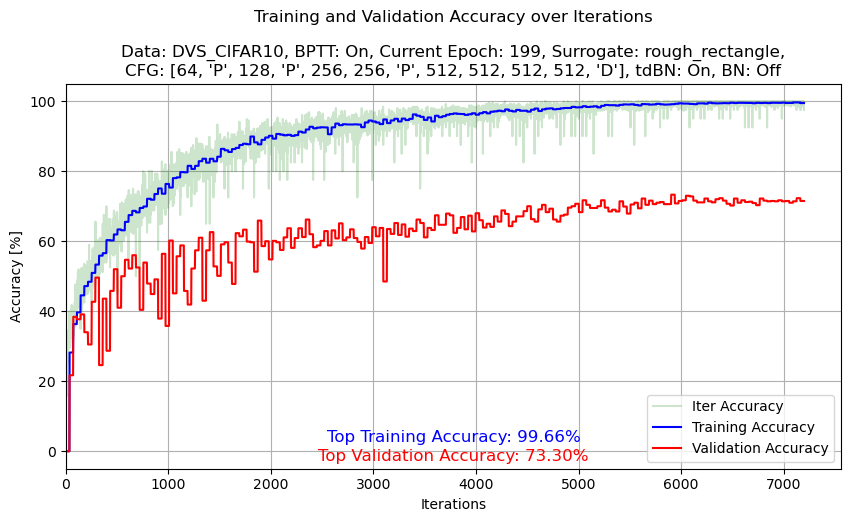

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def pad_array_to_match_length(array1, array2):
    if len(array1) > len(array2):
        padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
        return array1, padded_array2
    elif len(array2) > len(array1):
        padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
        return padded_array1, array2
    else:
        return array1, array2
def load_hyperparameters(filename='hyperparameters.json'):
    with open(filename, 'r') as f:
        return json.load(f)
    




current_time = '20240628_110116'
base_name = f'{current_time}'
iter_acc_file_name = f'result_save/{base_name}_iter_acc_array.npy'
val_acc_file_name = f'result_save/{base_name}_val_acc_now_array.npy'
hyperparameters_file_name = f'result_save/{base_name}_hyperparameters.json'

### if you want to just see most recent train and val acc###########################
iter_acc_file_name = 'result_save/iter_acc_array.npy'
tr_acc_file_name = 'result_save/tr_acc_array.npy'
val_acc_file_name = 'result_save/val_acc_now_array.npy'
hyperparameters_file_name = 'result_save/hyperparameters.json'

loaded_iter_acc_array = np.load(iter_acc_file_name)*100
loaded_tr_acc_array = np.load(tr_acc_file_name)*100
loaded_val_acc_array = np.load(val_acc_file_name)*100
hyperparameters = load_hyperparameters(hyperparameters_file_name)

loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

top_iter_acc = np.max(loaded_iter_acc_array)
top_tr_acc = np.max(loaded_tr_acc_array)
top_val_acc = np.max(loaded_val_acc_array)

which_data = hyperparameters['which_data']
BPTT_on = hyperparameters['BPTT_on']
current_epoch = hyperparameters['current epoch']
surrogate = hyperparameters['surrogate']
cfg = hyperparameters['cfg']
tdBN_on = hyperparameters['tdBN_on']
BN_on = hyperparameters['BN_on']


iterations = np.arange(len(loaded_iter_acc_array))

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # 텍스트 추가
# plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# 텍스트 추가
plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

plt.xlabel('Iterations')
plt.ylabel('Accuracy [%]')

# 그래프 제목에 하이퍼파라미터 정보 추가
title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

plt.title(title)

plt.legend(loc='lower right')
plt.xlim(0)  # x축을 0부터 시작
plt.grid(True)
plt.show()